# Generate hillshaded DEA Intertidal animations

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [8]:
%load_ext autoreload
%autoreload 2

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import datacube
import xarray as xr
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import xr_animation
from IPython.display import Video

from intertidal.utils import intertidal_hillshade

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

client = create_local_dask_cluster(return_client=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

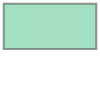

In [139]:
# Plot interactive map to select area
from ipyleaflet import basemap_to_tiles, basemaps
from odc.ui import select_on_a_map

basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

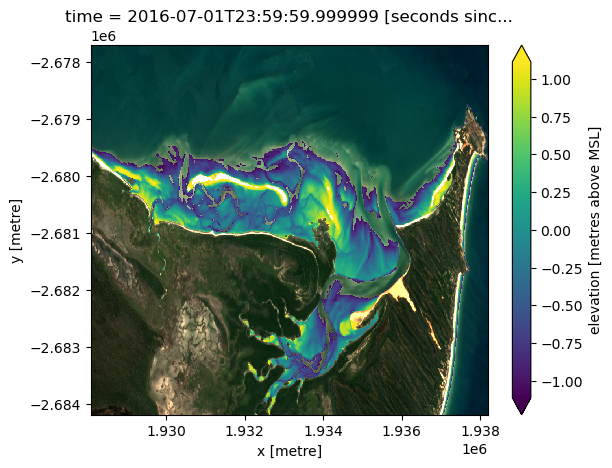

In [148]:
# # Cape Capricorn
# name = "capecapricorn"
# s2_product = "ga_s2bm_ard_3"
# s2_date = "2023-07-01"
# t, l = -23.491, 151.142
# b, r = -23.531, 151.241
# query_params = dict(x=(l, r), y=(t, b))

# # Burdekin
# name = "burdekin"
# s2_product = "ga_s2am_ard_3"
# s2_date = "2023-07-09"
# t, l = -19.615, 147.555
# b, r = -19.659, 147.615
# query_params = dict(x=(l, r), y=(t, b))

# # Pilbara
# name = "pilbara"
# s2_product = "ga_s2bm_ard_3"
# s2_date = "2023-07-23"
# t, l = -20.76, 116.44
# b, r = -20.825, 116.53
# query_params = dict(x=(l, r), y=(t, b))

# # Spoilbank
# name = "spoilbank"
# s2_product = "ga_s2am_ard_3"
# s2_date = "2023-07-15"
# t, l = -20.28, 118.575
# b, r = -20.32, 118.66
# query_params = dict(x=(l, r), y=(t, b))


name = "capecapricorn"
s2_product = "ga_s2_tidal_composites_cyear_3"
s2_date = "2022"
t, l = -23.491, 151.142
b, r = -23.531, 151.241
query_params = dict(x=(l, r), y=(t, b))

name = "kingsound"
s2_product = "ga_s2_tidal_composites_cyear_3"
s2_date = "2022"
t, l = -16.98, 123.23
b, r = -17.04, 123.30
query_params = dict(x=(l, r), y=(t, b))

name = "interactive"
s2_product = "ga_s2_tidal_composites_cyear_3"
s2_date = "2022"
t, l = -16.98, 123.23
b, r = -17.04, 123.30
query_params = dict(geopolygon=geom)


load_params = dict(
    dask_chunks={},
)

ds = (
    dc.load(
        product="ga_s2ls_intertidal_cyear_3", measurements=["elevation", "qa_ndwi_freq"], **query_params, **load_params
    )
    .squeeze()
    .compute()
)


ds_rgb = (
    dc.load(
        product=s2_product,
        measurements=["low_red", "low_green", "low_blue"],
        # time=s2_date,
        like=ds.odc.geobox.compat,
        # group_by="solar_day",
        dask_chunks={},
    )
    .squeeze()
    .compute()
)

ds_rgb.isel(time=0).to_array().plot.imshow(robust=True)
ds.isel(time=0).elevation.plot.imshow(ax=plt.gca(), cmap="viridis", robust=True)

In [145]:
years = [str(i.item()) for i in ds_rgb.time.dt.year]

vmin, vmax = ds.elevation.quantile([0.03, 0.95]).values

out_list = []
for year in years:
    out_list.append(
        intertidal_hillshade(
            elevation=ds.elevation.sel(time=year).squeeze(),
            freq=ds.qa_ndwi_freq.sel(time=year).squeeze(),
            altdeg=45,
            vert_exag=500,
            vmin=vmin,
            vmax=vmax,
            fraction=1,
        )
    )

intertidal_da = xr.concat(out_list, dim="time")
intertidal_da = intertidal_da.odc.assign_crs("EPSG:3577")

# Mask to keep pixels with valid data in all timesteps
# intertidal_da = intertidal_da.where(ds.elevation.notnull().all(dim="time"))
intertidal_da = intertidal_da.where(ds.elevation.notnull().mean(dim="time") > 0.15)

ds_rgba = ds_rgb.odc.to_rgba(vmin=0, vmax=2000).rename(band="variables")
intertidal_ds = intertidal_da.fillna(ds_rgba * 1.2).clip(0, 255).astype(np.uint8).to_dataset("variables")
intertidal_ds = intertidal_ds.odc.assign_crs("EPSG:3577")

Exporting animation to DEAIntertidal_timeseries_animation_interactive.mp4


  0%|          | 0/42 (0.0 seconds remaining at ? frames/s)

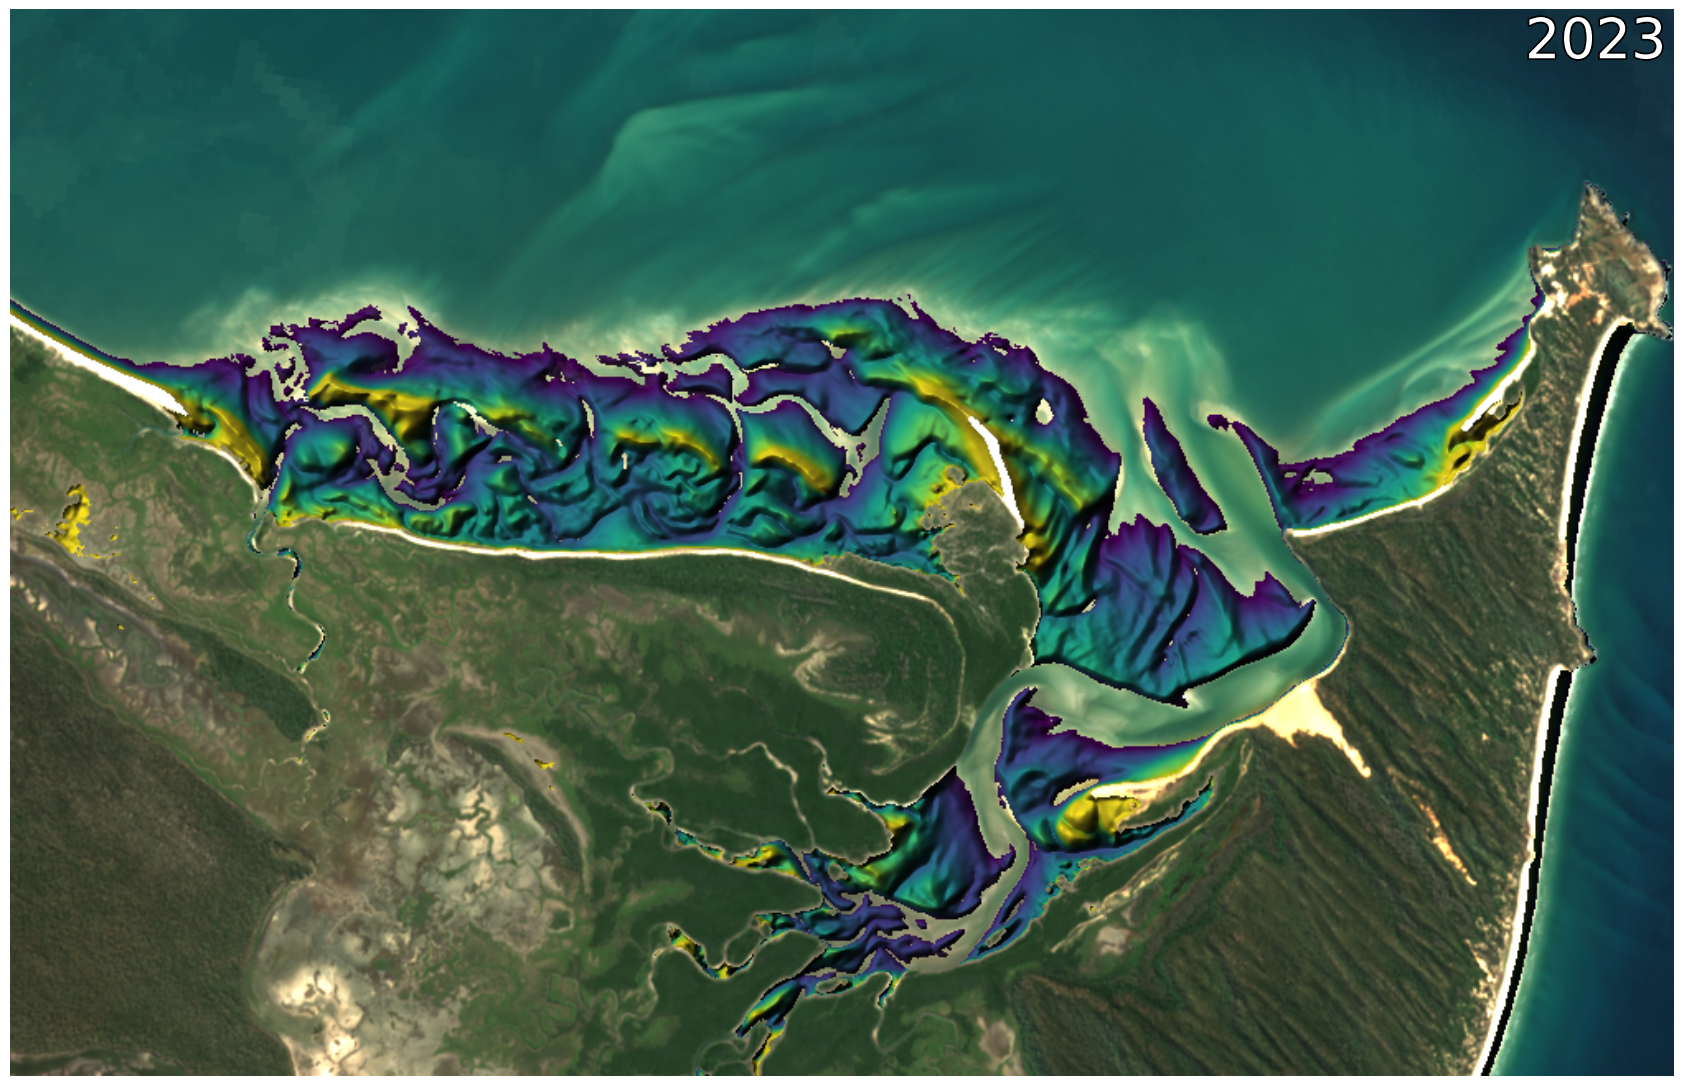

In [146]:
fname = f"DEAIntertidal_timeseries_animation_{name}.mp4"
xr_animation(
    ds=intertidal_ds.interp(
        time=pd.date_range(intertidal_ds.time[0].values, intertidal_ds.time[-1].values, freq="2ME", inclusive="both")
    ),
    bands=["r", "g", "b"],
    imshow_kwargs={"vmin": 0, "vmax": 255, "interpolation": "bilinear"},
    output_path=fname,
    interval=40,
    show_date="%Y",
    width_pixels=1200,
    annotation_kwargs={"fontsize": 40},
    # limit=3,
)
Video(fname, embed=True, width=600, html_attributes="loop autoplay")

In [129]:
# for n, (i, da) in enumerate(intertidal_ds.interp(time=pd.date_range("2016-07-02", "2022-07-01", freq="3M", inclusive="both")).groupby("time")):
#     print(i)

#     plt.imsave(f"intertidal_{n}.jpg", np.ascontiguousarray(da.to_array().astype(np.uint8).transpose("y", "x", "variable").values))

## Experimental: export DEM and RGB imagery for visualisation
This can be used to create a continuous psuedo DEM that covers the entire analysis area by filling the upper and lower areas of the map with the highest and lowest elevations from the intertidal DEM.

In [149]:
freq = ds.qa_ndwi_freq.copy()
elev = ds.elevation.copy()
elev_min, elev_max = elev.quantile([0, 1])

dem = xr.where(elev.isnull() & (freq < 50), elev_max, elev).fillna(elev_min)

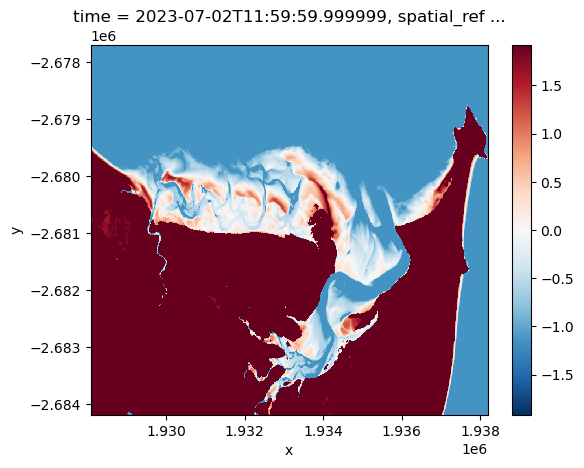

In [157]:
dem.isel(time=7).plot.imshow()

In [161]:
ds_rgb.isel(time=0).to_array().odc.write_cog("rgb.tif")

PosixPath('rgb.tif')

In [164]:
dem.odc.assign_crs(crs=ds_rgb.odc.crs).isel(time=0).odc.write_cog("dem.tif")

PosixPath('dem.tif')